In [1]:
####### LIBRARIES ######

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFECV

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, classification_report


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.base import clone

from scipy.stats import expon, uniform, randint

from xgboost import XGBClassifier

import joblib
import os


First, use our combined data `filtered.csv` with preliminary treatment above. Do the train-test split. Note that the data here is quite small, only about 1400 rows. After splitting, we want to make sure that both the train and test sets are representative of the whole dataset. For that, we are using <i>stratified sampling</i>.

In [15]:
# split the data into train and test set
from sklearn.model_selection import StratifiedShuffleSplit
dataset  = pd.read_csv('filetered.csv', index_col=0)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(dataset, dataset['yearCombine']):
    train = dataset.loc[train_index]
    test = dataset.loc[test_index]

In [16]:
dataset

,player_id,player_name,yearDraft,yearCombine,numberPickOverall,position,height,weight,wingspan,reach_standing,standing_vertical,max_vertical,bench_reps,timeLaneAgility,timeThreeQuarterCourtSprint,timeModifiedLaneAgility,lengthHandInches,widthHandInches,body_fat_pct,drafted
0,2124.0,Malik Allen,NaN,2000,NaN,PF-C,80.25,271.0,86.50,109.0,25.5,29.0,13.0,11.83,3.38,NaN,NaN,NaN,NaN,False
1,12019.0,Harold Arceneaux,NaN,2000,NaN,SG-SF,76.50,219.0,80.50,103.0,NaN,29.0,0.0,13.80,NaN,NaN,NaN,NaN,NaN,False
2,12020.0,Lamont Barnes,NaN,2000,NaN,PF-C,80.50,235.5,87.50,108.0,28.0,29.5,10.0,12.30,3.40,NaN,NaN,NaN,NaN,False
3,12131.0,Mario Bland,NaN,2000,NaN,PF,77.50,287.0,84.00,103.0,27.0,31.0,15.0,13.04,3.47,NaN,NaN,NaN,NaN,False
4,2056.0,Primoz Brezec,2000.0,2000,27.0,C,84.75,243.0,86.00,110.0,26.0,29.5,NaN,11.53,3.55,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1390,1630214.0,Xavier Tillman Sr.,2020.0,2020,35.0,PF-C,79.50,266.5,86.00,106.0,26.0,32.5,NaN,11.80,3.49,3.01,10.25,11.00,8.5,True
1391,1629700.0,Kaleb Wesson,NaN,2020,NaN,C,81.25,252.6,87.50,111.5,21.5,27.0,NaN,11.73,3.60,2.64,9.00,10.75,12.5,False
1392,1630232.0,Kahlil Whitney,NaN,2020,NaN,SF,77.50,205.0,84.25,105.5,29.0,39.0,NaN,11.17,3.28,2.61,9.25,10.25,5.3,False
1393,1630216.0,Cassius Winston,2020.0,2020,53.0,PG,72.50,196.0,78.00,97.0,24.0,28.0,NaN,11.15,3.61,2.74,8.75,8.25,9.0,True


The columns *player_id, player_name, yearDraft*, and *numberPickOverall* are to be dropped as the existence of yearDraft means the player was drafted. We would get 100% accuracy by including this column.


In [17]:
train_label = train['drafted']

# drop columns
train = train.drop(['player_id', 'player_name', 'yearDraft', 'numberPickOverall', 'drafted'], axis=1)


num_other_cols = ['yearCombine', 'standing_vertical', 'max_vertical', 'bench_reps', 'timeLaneAgility', 'timeThreeQuarterCourtSprint', 'timeModifiedLaneAgility', 'lengthHandInches', 'widthHandInches', 'body_fat_pct']
cat_cols = train.select_dtypes(exclude=['float64', 'int64']).columns
num_impute_cols = ['height', 'weight', 'wingspan', 'reach_standing']

In [18]:
train

,yearCombine,position,height,weight,wingspan,reach_standing,standing_vertical,max_vertical,bench_reps,timeLaneAgility,timeThreeQuarterCourtSprint,timeModifiedLaneAgility,lengthHandInches,widthHandInches,body_fat_pct
835,2011,PG,73.50,187.6,77.50,99.0,28.5,34.0,9.0,11.05,3.17,NaN,8.50,9.25,5.6
849,2012,SG,75.25,201.8,80.00,100.0,33.0,39.0,8.0,10.95,3.28,NaN,8.50,9.00,6.0
6,2000,PG,70.50,166.0,72.00,94.5,36.0,42.5,6.0,10.48,3.06,NaN,NaN,NaN,NaN
827,2011,SF,80.75,221.2,81.50,104.5,25.5,31.5,4.0,11.05,3.29,NaN,8.25,10.00,7.0
687,2008,SG-PG,72.75,166.2,79.25,98.0,31.0,39.0,2.0,10.98,3.08,NaN,NaN,NaN,3.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1331,2019,SF,79.25,209.6,85.75,106.5,30.5,37.0,9.0,10.88,3.38,3.13,9.25,9.25,4.6
7,2000,SG-SF,76.00,205.0,83.00,102.0,35.0,38.0,10.0,11.40,3.15,NaN,NaN,NaN,NaN
36,2000,PG-SG,73.50,205.5,76.50,97.5,31.0,38.5,24.0,10.99,3.31,NaN,NaN,NaN,NaN
1160,2017,SG-SF,77.00,220.2,78.00,100.5,31.0,37.5,16.0,11.14,3.21,3.24,8.25,9.25,7.5


**After splitting, we noticed that there are more preprocessing to go with the missing data, categorial variables, and etc. So we create a preprocessing pipiline beblow.**

# Preprocessing Pipeline

We are creating a pipeline here to:

* Impute columns in num_impute_cols
* Create dummy variables of positions with OneHotEncoder after it has been split to primary and secondary positions
* Leave the rest of the columns be

This approach works because XGBoost is a tree-based method, it requires no scaling.

In [2]:
######################## CUSTOM TRANSFORMER FOR PREPROCESSING ##################
class CustomTransformer(BaseEstimator, TransformerMixin):
    """Custom Transformer to add positions features"""
    
    def __init__(self):
        ...


    def fit(self, X, y=None):
        return self      
    

    def transform(self, X):
        X = X.copy()
        temp_cols = X.columns.to_list()
        X = add_positions(X)
        
        return X  


def add_positions(data):
    data[['primary_position', 'secondary_position']] = data['position'].str.split('-', expand=True)

    data = data.drop('position', axis=1)
    return data


######################## FEATURE SELECTOR #####################################
def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])


class TopFeatureSelector(BaseEstimator, TransformerMixin):
    """Create a TopFeatureSelector object to select features automatically in an Sklearn Pipeline
    provided that user has decided on the optimal number of features"""

    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k


    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self

        
    def transform(self, X):
        return X[:, self.feature_indices_]

In [20]:
num_impute_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median'))
])

cat_pipe = Pipeline([
        ('custom_transform', CustomTransformer()),
        ('encoder', OneHotEncoder()),
])  



In [21]:
preprocess_pipeline = ColumnTransformer([
        ('num_impute', num_impute_pipe, num_impute_cols),
        ('custom_transformer', cat_pipe, cat_cols),
        ], remainder='passthrough')

train_prepared = preprocess_pipeline.fit_transform(train)


In [22]:
train_prepared.shape

(1116, 27)

In [23]:
train_prepared[333]

array([7.575e+01, 2.026e+02, 8.100e+01, 1.010e+02, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.010e+03,
       3.100e+01, 4.000e+01, 1.000e+01, 1.138e+01, 3.150e+00,       nan,
       9.000e+00, 1.050e+01, 3.700e+00])

Note that OneHotEncoder created 13 new columns based on positions. 

# Pipeline with Model

Now we begine with the predicting model 

In [ ]:
full_pipeline_with_predictor = Pipeline([
        ('preparation', preprocess_pipeline),
        ('xgboost', XGBClassifier())
])

predictions = cross_val_predict(full_pipeline_with_predictor, train, train_label)

In [25]:
predictions

array([ True,  True, False, ..., False,  True, False])

In [26]:
confusion_matrix(train_label, predictions)

array([[237, 222],
       [167, 490]])

In [27]:
print(classification_report(train_label, predictions))

              precision    recall  f1-score   support

       False       0.59      0.52      0.55       459
        True       0.69      0.75      0.72       657

    accuracy                           0.65      1116
   macro avg       0.64      0.63      0.63      1116
weighted avg       0.65      0.65      0.65      1116



Given a default model, the outcomes are decent enough. The quality of the data isn't particularly excellent. Aiming to increase its perfromance, we conduct a random search with `RandomizedSearchCV` based on f1 score

# Hyperparameter Tuning with RandomizedSearch

In [ ]:
param_distribs = {
    'xgboost__n_estimators': randint(50, 250),
    'xgboost__gamma': expon(scale=1.0),
    'xgboost__max_depth': [3,4,5,6],
    'xgboost__learning_rate': uniform(0, 1),
    'xgboost__scale_pos_weight': uniform(0, 1)
}

rnd_search = RandomizedSearchCV(
    estimator=full_pipeline_with_predictor,
    param_distributions=param_distribs,
    n_iter=1000, cv=5,
    scoring='f1',
    verbose=1, random_state=42
)

rnd_search.fit(train,train_label)

In [29]:
rnd_search.best_params_

{'xgboost__gamma': 1.0377256120492335,
 'xgboost__learning_rate': 0.04477845050466822,
 'xgboost__max_depth': 3,
 'xgboost__n_estimators': 242,
 'xgboost__scale_pos_weight': 0.9466444339935463}

In [31]:
best_params = {'gamma': 1.0377256120492335,
 'learning_rate': 0.04477845050466822,
 'max_depth': 3,
 'n_estimators': 242,
 'scale_pos_weight': 0.9466444339935463}

In [32]:
model_all_features = Pipeline([
        ('preparation', preprocess_pipeline),
        ('xgboost', XGBClassifier(**best_params))
])

In [80]:
### save the model to local
joblib.dump(model_all_features, 'model_1.pkl')

['model_1.pkl']

# Feature Importances

In [34]:
my_model = XGBClassifier(**best_params)

In [35]:
my_model.fit(train_prepared, train_label)

[17:08:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1.0377256120492335,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.04477845050466822, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=242, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.9466444339935463,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [36]:
feature_importances = my_model.feature_importances_

In [37]:
feature_importances

array([0.03999785, 0.02956992, 0.04681499, 0.03853495, 0.03565304,
       0.03153887, 0.03448423, 0.02846371, 0.        , 0.        ,
       0.01701788, 0.03098894, 0.        , 0.03183281, 0.02612257,
       0.0503971 , 0.        , 0.20724289, 0.04270481, 0.02866271,
       0.0294596 , 0.04154231, 0.03288832, 0.04741919, 0.03803423,
       0.04754926, 0.0430798 ], dtype=float32)

In [38]:
cat_encoder = preprocess_pipeline.named_transformers_.custom_transformer.named_steps['encoder']
cat_one_hot_attribs = list(np.concatenate(cat_encoder.categories_[:]))

In [39]:
cat_one_hot_attribs = [str(i) for i in cat_one_hot_attribs]

In [40]:
attributes = num_impute_cols  + cat_one_hot_attribs + num_other_cols

In [42]:

sorted(zip(feature_importances, attributes), reverse=True)

[(0.20724289, 'yearCombine'),
 (0.0503971, 'None'),
 (0.047549255, 'widthHandInches'),
 (0.047419187, 'timeModifiedLaneAgility'),
 (0.046814993, 'wingspan'),
 (0.0430798, 'body_fat_pct'),
 (0.04270481, 'standing_vertical'),
 (0.041542314, 'timeLaneAgility'),
 (0.039997846, 'height'),
 (0.038534954, 'reach_standing'),
 (0.038034227, 'lengthHandInches'),
 (0.03565304, 'C'),
 (0.03448423, 'PG'),
 (0.032888316, 'timeThreeQuarterCourtSprint'),
 (0.03183281, 'SF'),
 (0.03153887, 'PF'),
 (0.030988941, 'PF'),
 (0.029569918, 'weight'),
 (0.029459601, 'bench_reps'),
 (0.028662713, 'max_vertical'),
 (0.02846371, 'SF'),
 (0.026122568, 'SG'),
 (0.017017882, 'C'),
 (0.0, 'nan'),
 (0.0, 'nan'),
 (0.0, 'SG'),
 (0.0, 'PG')]

Looks like secondary position in general isn't really important for NBA scouts. Strong physical attributes like standing vertical and reach standing are the more important features here.
And the most important feature is *yearCombine*, which also makes some sense since the year of the combine should mean that drafting criteria also changes as the NBA undergo changes in style.

# Feature Selection

We've seen that some features got zero importances, so perhaps trimming down on the number of features could make our model more robust. 

In [ ]:
min_features_to_select = 5  # Minimum number of features to consider
rfecv = RFECV(
    estimator=clone(my_model), # make a clone of model that is unfitted
    step=1,
    cv=StratifiedKFold(5),
    scoring="f1",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(train_prepared,train_label)


In [44]:

print("Optimal number of features : %d" % rfecv.n_features_)


Optimal number of features : 21


In [ ]:

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (F1-Score)")
plt.plot(
    range(min_features_to_select, len(rfecv.cv_results_['mean_test_score']) + min_features_to_select),
    rfecv.cv_results_['mean_test_score'],
)
plt.show()

In [85]:
rfecv.grid_scores_

array([0.70594587, 0.71638759, 0.71598183, 0.71780536, 0.71231847,
       0.71774891, 0.72635687, 0.71377855, 0.7174683 , 0.71503503,
       0.71581784, 0.72500058, 0.72293584, 0.72755756, 0.73139405,
       0.72908146, 0.73232457, 0.7264029 , 0.72786276, 0.73125753,
       0.73125753, 0.73125753, 0.73125753])

In [58]:
# use a predefined function to get the indices of 15 most important features
top_15_indices = indices_of_top_k(feature_importances, 15)
np.array(attributes)[top_15_indices]

array(['height', 'wingspan', 'reach_standing', 'C', 'PG', 'SF', 'None',
       'yearCombine', 'standing_vertical', 'timeLaneAgility',
       'timeThreeQuarterCourtSprint', 'timeModifiedLaneAgility',
       'lengthHandInches', 'widthHandInches', 'body_fat_pct'],
      dtype='<U27')

In [59]:
# check if function return correct attributes
sorted(zip(feature_importances, attributes), reverse=True)[:15]

[(0.20724289, 'yearCombine'),
 (0.0503971, 'None'),
 (0.047549255, 'widthHandInches'),
 (0.047419187, 'timeModifiedLaneAgility'),
 (0.046814993, 'wingspan'),
 (0.0430798, 'body_fat_pct'),
 (0.04270481, 'standing_vertical'),
 (0.041542314, 'timeLaneAgility'),
 (0.039997846, 'height'),
 (0.038534954, 'reach_standing'),
 (0.038034227, 'lengthHandInches'),
 (0.03565304, 'C'),
 (0.03448423, 'PG'),
 (0.032888316, 'timeThreeQuarterCourtSprint'),
 (0.03183281, 'SF')]

## Preprocessing and Feature Selection Pipeline

Quick test of adding feature selection to a pipeline before integrating it to a complete end-to-end pipeline.

In [60]:
preprocess_and_feature_selection_pipeline = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, 15))
])

In [61]:
players_prepared_top15_features = preprocess_and_feature_selection_pipeline.fit_transform(train)

In [62]:
players_prepared_top15_features[0:3]

array([[7.350e+01, 7.750e+01, 9.900e+01, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 2.011e+03, 2.850e+01, 1.105e+01, 3.170e+00,       nan,
        8.500e+00, 9.250e+00, 5.600e+00],
       [7.525e+01, 8.000e+01, 1.000e+02, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 2.012e+03, 3.300e+01, 1.095e+01, 3.280e+00,       nan,
        8.500e+00, 9.000e+00, 6.000e+00],
       [7.050e+01, 7.200e+01, 9.450e+01, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 2.000e+03, 3.600e+01, 1.048e+01, 3.060e+00,       nan,
              nan,       nan,       nan]])

In [63]:
train_prepared[0:3, top_15_indices]

array([[7.350e+01, 7.750e+01, 9.900e+01, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 2.011e+03, 2.850e+01, 1.105e+01, 3.170e+00,       nan,
        8.500e+00, 9.250e+00, 5.600e+00],
       [7.525e+01, 8.000e+01, 1.000e+02, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 2.012e+03, 3.300e+01, 1.095e+01, 3.280e+00,       nan,
        8.500e+00, 9.000e+00, 6.000e+00],
       [7.050e+01, 7.200e+01, 9.450e+01, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 2.000e+03, 3.600e+01, 1.048e+01, 3.060e+00,       nan,
              nan,       nan,       nan]])

Okay, looks good!

In [64]:
model_1 = joblib.load('model_1.pkl') # randomized search with all features


In [ ]:
model_1_preds = cross_val_predict(model_1, train, train_label)

In [67]:
print(classification_report(train_label, model_1_preds))

              precision    recall  f1-score   support

       False       0.62      0.56      0.59       459
        True       0.71      0.76      0.73       657

    accuracy                           0.68      1116
   macro avg       0.66      0.66      0.66      1116
weighted avg       0.67      0.68      0.67      1116



# ERROR ANALYSIS

We present the basic metrics for classification tasks, the confusiton metric, f1, and etc. And we plot the roc curve for more understantding of the results. Also, we tried to modify the threshhold to see how the result goes.

In [ ]:
y_probas = cross_val_predict(model_1, train, train_label, cv=5, method='predict_proba')

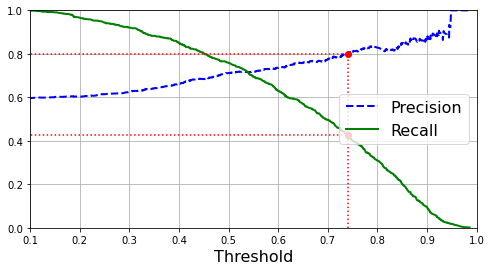

In [69]:
precisions, recalls, thresholds = precision_recall_curve(train_label, y_probas[:,1])

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([0.1, 1, 0, 1])             



recall_80_precision = recalls[np.argmax(precisions >= 0.8)]
threshold_80_precision = thresholds[np.argmax(precisions >= 0.8)]


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_80_precision, threshold_80_precision], [0., 0.8], "r:")                 
plt.plot([0, threshold_80_precision], [0.8, 0.8], "r:")                                
plt.plot([0, threshold_80_precision], [recall_80_precision, recall_80_precision], "r:")
plt.plot([threshold_80_precision], [0.8], "ro")                                             
plt.plot([threshold_80_precision], [recall_80_precision], "ro")                             
("precision_recall_vs_threshold_plot")                                              
plt.show()

In [ ]:
y_pred_precision = (y_probas > 0.6)

In [ ]:
print(classification_report(train_label, y_pred_precision[:,1]))

              precision    recall  f1-score   support

       False       0.57      0.73      0.64       466
        True       0.76      0.60      0.67       650

    accuracy                           0.66      1116
   macro avg       0.66      0.67      0.66      1116
weighted avg       0.68      0.66      0.66      1116



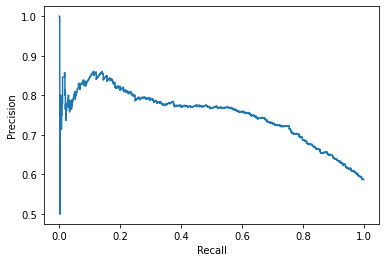

In [ ]:
disp = PrecisionRecallDisplay(precisions, recalls)
disp.plot()

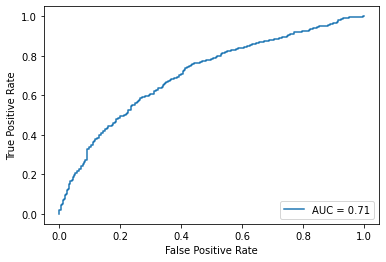

In [89]:
fpr, tpr, thresholds = roc_curve(train_label, y_probas[:,1])

roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()

In [74]:
final_model = model_1.fit(train, train_label)

/Applications/anaconda3/envs/IML/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:26:59] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [99]:
joblib.dump(model_all_features, 'model_final.pkl')

['model_final.pkl']

# Test the trained model
use the model to predict the test set. 

In [71]:
cols_to_drop = ['player_id', 'player_name', 'yearDraft', 'numberPickOverall', 'drafted']

X_test = test.drop(cols_to_drop, axis=1)
y_test = test['drafted']

In [97]:
y_pred = (final_model.predict_proba(X_test) > 0.6)[:, 1] # use the threshold decided above

In [98]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.59      0.61      0.60       127
        True       0.67      0.64      0.66       152

    accuracy                           0.63       279
   macro avg       0.63      0.63      0.63       279
weighted avg       0.63      0.63      0.63       279



There's slight drop in overall accuracy, from 66% to 63%, which is acceptable and indicate no overfitting. Also, based on the number of data records, and the relevance of features, this performance is decent enough. Next and last, we will see how the model actual precition of the top draft picks.


In [77]:
y_top5 = test[test.numberPickOverall <= 5]['drafted']
X_top5 = test[test.numberPickOverall <= 5].drop(cols_to_drop, axis=1)

y_top5_pred = (final_model.predict_proba(X_top5) > 0.6)[:, 1]

In [78]:
len(y_top5_pred)

16

In [79]:
top5_picks = test[test.numberPickOverall <= 5]
top5_picks['prediction'] = y_top5_pred

top5_picks[['player_name', 'numberPickOverall', 'prediction']].loc[top5_picks.prediction==False]

/var/folders/rz/wj2pwbn164x144wk9djnk2840000gn/T/ipykernel_73536/1590401348.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top5_picks['prediction'] = y_top5_pred


,player_name,numberPickOverall,prediction
173,Drew Gooden,4.0,False
549,Mike Conley,4.0,False
751,DeMarcus Cousins,5.0,False
334,Dwight Howard,1.0,False
557,Kevin Durant,2.0,False
